In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from numpy import pi, e
from numpy.linalg import inv, det
from numpy.linalg import norm as LA_norm
from numpy.random import random
from scipy.stats import norm
from sklearn.datasets import make_spd_matrix
from termcolor import colored

In [2]:
def create_matrix(m, n):
    return np.random.rand(m, n)

def initial_inputs(flag, is_diagonal):
    if flag == 0:
        # Create initial encoder inputs (B, Sigma_W)
        B = create_matrix(m, n)
        Sigma_W = make_spd_matrix(m)
        return np.concatenate(([flag], B.reshape((m*n)), Sigma_W.reshape((m*m))))
    else:
        # Create initial decoder inputs (A, Sigma_Z)
        A = create_matrix(n, m)
        
        if is_diagonal == 0:
            Sigma_Z = make_spd_matrix(n)
        else:
            Sigma_Z = np.diag(random(n))
            
        return np.concatenate(([flag], A.reshape((n*m)), Sigma_Z.reshape((n*n))))

def matrix_B(A, Sigma_Z):
    B = gamma * inv(np.identity(m) + gamma * A.T @ inv(Sigma_Z) @ A) @ A.T @ inv(Sigma_Z)
    return B

def covariance_matrix_W(A, Sigma_Z):
    Sigma_W = inv(np.identity(m) + gamma * A.T @ inv(Sigma_Z) @ A)
    return Sigma_W

def matrix_A(B, Sigma_W):
    A = inv(inv(Sigma_Y) + B.T @ inv(Sigma_W) @ B) @ B.T @ inv(Sigma_W)
    return A

def covariance_matrix_Z(B, Sigma_W, is_diagonal):
    Sigma_Z = inv(inv(Sigma_Y) + B.T @ inv(Sigma_W) @ B)
    diagonalized_Sigma_Z = np.diag(Sigma_Z.diagonal())
    
    if is_diagonal == 0:
        return Sigma_Z
    else:
        return diagonalized_Sigma_Z

def encoder_mi(B, Sigma_W):
    return 0.5 * np.log(det(B @ Sigma_Y @ B.T + Sigma_W) / det(Sigma_W))

def decoder_mi(A, Sigma_Z):
    return 0.5 * np.log(det(A @ A.T + Sigma_Z) / det(Sigma_Z))

def reconstruction_error(recon, orig):
    norm_diff = LA_norm(orig - recon, 2)
    orig_norm = LA_norm(orig, 2)
    recon_err = norm_diff / orig_norm
    return recon_err
    
def objective_function(A, B, Sigma_Z, Sigma_W):
    Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
    
    regularizer = 0.5 * (np.trace(Sigma_X) - np.log(det(Sigma_W)) - m)
    reconstruction = 0.5 * (np.trace(Sigma_X) + \
                            np.trace(A.T @ inv(Sigma_Z) @ Sigma_Y @ B.T) + \
                            np.trace(inv(Sigma_Z) @ A @ B @ Sigma_Y) - \
                            np.trace(inv(Sigma_Z) @ Sigma_Y) - \
                            np.trace((np.identity(m) + A.T @ inv(Sigma_Z) @ A) @ Sigma_X) - \
                            n * np.log(2 * pi) - np.log(det(Sigma_Z)))
    
    return regularizer - gamma * reconstruction

In [3]:
def plot_cost_function(cf_arr):
    """
    Plot values of objective function against iterations t
    """
    plt.plot(range(1, len(cf_arr) + 1), cf_arr)
    plt.xlabel('t')
    plt.ylabel('Cost Function', fontsize=10)
    plt.show()

def plot_encoder_mi(en_mi_arr):
    """
    Plot mutual information of encoder against iterations t
    """
    plt.plot(range(1, len(en_mi_arr) + 1), en_mi_arr)
    plt.xlabel('t')
    plt.ylabel('Mutual Information of Encoder', fontsize=10)
    plt.show()

def plot_decoder_mi(de_mi_arr):
    """
    Plot mutual information of decoder against iterations t
    """
    plt.plot(range(1, len(de_mi_arr) + 1), de_mi_arr)
    plt.xlabel('t')
    plt.ylabel('Mutual Information of Decoder', fontsize=10)
    plt.show()

In [4]:
def print_optimal_solution(sol, m):
    A_arr = sol[:n*m] 
    B_arr = sol[n*m:2*n*m]
    Sigma_Z_arr = sol[2*n*m:2*n*m+n*n]
    Sigma_Z = Sigma_Z_arr.reshape((n, n))
    Sigma_W_arr = sol[2*n*m+n*n:2*n*m+n*n+m*m]
    Sigma_W = Sigma_W_arr.reshape((m, m))
    cost_function = sol[2*n*m+n*n+m*m:2*n*m+n*n+m*m+1][0]
    en_mi = sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0]
    de_mi = sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0]
    recon_err = sol[-1]
    len_cf_mi_arr = sol[2*n*m+n*n+m*m+3:2*n*m+n*n+m*m+6]
    Sigma_X = sol[2*n*m+n*n+m*m+6:2*n*m+n*n+2*m*m+6].reshape((m, m))
    Sigma_Y_hat = sol[2*n*m+n*n+2*m*m+6:2*n*m+2*n*n+2*m*m+6].reshape((n, n))
    
    print(colored('Optimal solution:', attrs=['bold']))
    
    if m > 1:
        print('Matrix A:\n{}'.format(np.round(A_arr.reshape((n, m)), 4)))
        print('\nMatrix B:\n{}'.format(np.round(B_arr.reshape((m, n)), 4)))
        print('\nCovariance matrix of Z:\n{}'.format(np.round(Sigma_Z, 4)))
        print('\nCovariance matrix of W:\n{}'.format(np.round(Sigma_W, 4)))
        print('\nMinimum value of the cost function:\n{}'.format(round(cost_function, 4)))
        print('\nMutual information of the encoder:\n{}'.format(round(en_mi, 4)))
        print('\nMutual information of the decoder:\n{}'.format(round(de_mi, 4)))
        print('\nValue of Sigma_X:\n{}'.format(np.round(Sigma_X, 4)))
        print('\nValue of Sigma_Y_hat:\n{}'.format(np.round(Sigma_Y_hat, 4)))
        print('\nReconstruction error:\n{}'.format(round(recon_err, 4)))
    else:
        print('Vector a:\n{}'.format(np.round(A_arr.reshape((n, m)), 4)))
        print('\nVector b:\n{}'.format(np.round(B_arr.reshape((m, n)), 4)[0]))
        print('\nCovariance matrix of Z:\n{}'.format(np.round(Sigma_Z, 4)))
        print('\nVariance of W:\n{}'.format(np.round(Sigma_W, 4)[0][0]))
        print('\nMinimum value of the cost function:\n{}'.format(round(cost_function, 4)))
        print('\nMutual information of the encoder:\n{}'.format(round(en_mi, 4)))
        print('\nMutual information of the decoder:\n{}'.format(round(de_mi, 4)))
        print('\nValue of Sigma_X:\n{}'.format(np.round(Sigma_X, 4)))
        print('\nValue of Sigma_Y_hat:\n{}'.format(np.round(Sigma_Y_hat, 4)))        
        print('\nReconstruction error:\n{}'.format(round(recon_err, 4)))
        
    return len_cf_mi_arr

def print_comprehensive_results(gamma, flag, m, n, is_diagonal):
    if flag == 0:
        # Generate random initial encoder inputs (B, Sigma_W)
        B, Sigma_W = initial_inputs(flag, is_diagonal)[1:1+m*n].reshape((m, n)), initial_inputs(flag, is_diagonal)[1+m*n:1+m*n+m*m].reshape((m, m))
    else:
        # Generate random initial decoder inputs (A, Sigma_Z)
        A, Sigma_Z = initial_inputs(flag, is_diagonal)[1:1+n*m].reshape((n, m)), initial_inputs(flag, is_diagonal)[1+n*m:1+n*m+n*n].reshape((n, n))
    
    # Print given inputs
    if m > 1 and flag == 0:
        print(colored('Given encoder X:', attrs=['bold']))
        print('Initial matrix B:')
        print(np.round(B.reshape((m, n)), 4))
        print('\nInitial covariance matrix of W:')
        print(np.round(Sigma_W, 4))
    elif m == 1 and flag == 0:
        print(colored('Given encoder X:', attrs=['bold']))
        print('Initial vector b:')
        print(np.round(B.reshape((m, n)), 4)[0])
        print('\nInitial variance of W:')
        print(np.round(Sigma_W, 4)[0][0])
    elif m > 1 and flag == 1:
        print(colored('Given decoder Y_hat:', attrs=['bold']))
        print('Initial matrix A:')
        print(np.round(A.reshape((n, m)), 4))
        print('\nInitial covariance matrix of Z:')
        print(np.round(Sigma_Z, 4))
    else:
        print(colored('Given decoder Y_hat:', attrs=['bold']))
        print('Initial vector a:')
        print(np.round(A.reshape((n, m)), 4))
        print('\nInitial covariance matrix of Z:')
        print(np.round(Sigma_Z, 4))      
    
    # Print results
    if flag == 0:
        # Compute optimal solution given encoder inputs
        opt_sol = rate_distortion(initial_inputs(flag, is_diagonal), is_diagonal)
    
        # Extract length of arrays for cost function and mutual information of encoder and decoder
        len_all_arrs = print_optimal_solution(opt_sol, m).astype(int)
        len_cf_arr, len_en_mi_arr = len_all_arrs[:2]
        len_cf_en_mi_arr = len_cf_arr + len_en_mi_arr
        
        # Plot values of cost function and mutual information against iterations
        cf_arr = opt_sol[2*n*m+2*n*n+2*m*m+6 : 2*n*m+2*n*n+2*m*m+6+len_cf_arr]
        plot_cost_function(cf_arr)
    
        en_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_arr : 2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr]
        plot_encoder_mi(en_mi_arr)
    
        de_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr:]
        plot_decoder_mi(de_mi_arr) 
    else:
        opt_sol = rate_distortion(initial_inputs(flag, is_diagonal), is_diagonal)
        
        len_all_arrs = print_optimal_solution(opt_sol, m).astype(int)
        len_cf_arr, len_en_mi_arr = len_all_arrs[:2]
        len_cf_en_mi_arr = len_cf_arr + len_en_mi_arr
        
        cf_arr = opt_sol[2*n*m+2*n*n+2*m*m+6 : 2*n*m+2*n*n+2*m*m+6+len_cf_arr]
        plot_cost_function(cf_arr)
    
        en_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_arr : 2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr]
        plot_encoder_mi(en_mi_arr)
    
        de_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr:]
        plot_decoder_mi(de_mi_arr) 

In [5]:
"""

*****************************************************************
**                          ALGORITHM                          **
*****************************************************************
   
Inputs:
- MAX_ITERS: Maximum number of iterations
- n, m: Dimensions of the matrix
- TOL_ERR: Tolerable error
- Sigma_Y: A random nxn positive definite matrix

Algorithm:
1. Initialize flag
    a. If we start with the encoder, set flag = 0.
    b. Otherwise, set flag = 1.
    
2. Generate initial inputs for the iteration step
    a. If flag = 0, then do:
        i. create random initial encoder inputs, including 
            - a random mxn matrix B
            - a random mxm positive definite covariance matrix Sigma_W
        ii. set flag = 1.
    b. If flag = 1, then do:
        i. create random initial decoder inputs, including 
            - a random nxm matrix A
            - a random nxn positive definite covariance matrix Sigma_Z
        ii. set flag = 0.
        
3. Set iteration counter i = 0. 

4. Iterative step
    a. If flag = 0, given the decoder inputs (A, Sigma_Z) at iteration i,
        i. compute the corresponding encoder inputs at iteration i+1:
            B = matrix_B(A, Sigma_Z)
            Sigma_W = covariance_matrix_W(A, Sigma_Z)
        ii. set flag = 1.
        iii. compute the resulting gamma-VAE cost function and mutual information of the encoder.
        iv. check if the cost function is NaN:
            - if it is, conclude that the algorithm fails to converge and skip to step 7.
        v. check for convergence after the second iteration:
            - if converges, conclude that the algorithm converges and skip to step 7.
            - unless, check if the maximum number of iterations has been reached:
                - if it is, conclude that the algorithm failed to converge and skip to step 7.
                - otherwise, move to step 5.
    b. If flag = 1, given the encoder inputs (B, Sigma_W) at iteration i,
        i. compute the corresponding decoder inputs at iteration i:
            A = matrix_A(B, Sigma_W)
            Sigma_Z = covariance_matrix_Z(B, Sigma_W, is_diagonal)
        ii. set flag = 0.
        iii. compute the resulting gamma-VAE cost function, mutual information of the decoder, and reconstruction error.
        iv. check if the cost function is NaN:
            - if it is, conclude that the algorithm fails to converge and skip to step 7.
        v. check for convergence after the second iteration:
            - if converges, conclude that the algorithm converges and skip to step 7.
            - unless, check if the maximum number of iterations has been reached:
                - if it is, conclude that the algorithm failed to converge and skip to step 7.
                - otherwise, move to step 5.
            
5. Increment iteration counter i <- i + 1.

6. If the iteration counter i < MAX_ITERS, then move back to step 4.
    Otherwise, move to step 7.
    
7. Compute the values of Sigma_X and Sigma_Y_hat.
        
8. Display results
    a. display the optimal solution (A, B, Sigma_Z, Sigma_W).
    b. display the corresponding minimum value of gamma-VAE cost function.
    c. display the resulting mutual information of both encoder and decoder.
    d. display the values of Sigma_X and Sigma_Y_hat.
    e. display the value of reconstruction error.
    f. move to step 9.
    
9. Stop.

"""

def rate_distortion(inputs, is_diagonal):
    flag = inputs[0]
    if flag == 0:
        B = inputs[1:1+m*n].reshape((m, n))
        Sigma_W = inputs[1+m*n:1+m*n+m*m].reshape((m, m))
        flag = 1
        # Array of current encoder inputs (B_t, Sigma_W_t)
        current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
    else:
        A = inputs[1:1+n*m].reshape((n, m))
        Sigma_Z = inputs[1+n*m:1+n*m+n*n].reshape((n, n))
        flag = 0
        # Array of current decoder inputs (A_t, Sigma_Z_t)
        current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
    
    # Cost function and mutual information arrays
    cf_arr = []
    en_mi_arr = []
    de_mi_arr = [] 
    
    # Iteration step
    try:
        for i in range(0, MAX_ITERS):
            if  flag == 0:
                B = matrix_B(A, Sigma_Z)
                Sigma_W = covariance_matrix_W(A, Sigma_Z)
                flag = 1
                
                # Check if the value of the cost function is not a number
                current_obj = objective_function(A, B, Sigma_Z, Sigma_W)
                if np.isnan(current_obj):
                    print(colored('\nThe algorithm fails to converge after {} iterations due to NaN values.\n'.format(i+1), 'red', attrs=['bold']))
                    break
                    
                cf_arr = np.concatenate((cf_arr, [current_obj]))
                current_en_mi = encoder_mi(B, Sigma_W)
                en_mi_arr = np.concatenate((en_mi_arr, [current_en_mi]))
                
                # For the first iteration, update the current encoder inputs and value of the cost function
                if i == 0:
                    current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
                    previous_obj = current_obj
                # From the second iteration,
                # 1. Compute the Frobenius norm of the difference between
                #    i. B and itself in the previous iteration
                #    ii. Sigma_W and itself in the previous iteration
                # 2. Compute the difference between the cost function and itself in the previous iteration
                # 3. Update the current encoder inputs and value of the cost function
                else:
                    B_diff = B - current_encoder_inputs[:m*n].reshape((m, n))
                    B_norm_diff = LA_norm(B_diff, 'fro')
                    Sigma_W_diff = Sigma_W - current_encoder_inputs[m*n:m*n+m*m].reshape((m, m))
                    Sigma_W_norm_diff = LA_norm(Sigma_W_diff, 'fro')
                    obj_diff = previous_obj - current_obj
                    previous_obj = current_obj
                    current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
                    # Check for convergence
                    if B_norm_diff <= TOL_ERR and Sigma_W_norm_diff <= TOL_ERR and round(obj_diff, 8) == 0:
                        print(colored('\nThe algorithm converges after {} iterations.\n'.format(i+1), 'blue', attrs=['bold']))
                        break
                    elif i == MAX_ITERS - 1:
                        print(colored('\nThe algorithm reaches the maximum number of iterations without convergence.\n', 'red', attrs=['bold']))
            else:
                A = matrix_A(B, Sigma_W)
                Sigma_Z = covariance_matrix_Z(B, Sigma_W, is_diagonal)
                flag = 0
                
                current_obj = objective_function(A, B, Sigma_Z, Sigma_W)
                if np.isnan(current_obj):
                    print(colored('\nThe algorithm fails to converge after {} iterations due to NaN values.\n'.format(i+1), 'red', attrs=['bold']))
                    break
                    
                cf_arr = np.concatenate((cf_arr, [current_obj]))
                current_de_mi = decoder_mi(A, Sigma_Z)
                de_mi_arr = np.concatenate((de_mi_arr, [current_de_mi]))
                
                Sigma_Y_hat = A @ A.T + Sigma_Z
                recon_err = reconstruction_error(Sigma_Y_hat, Sigma_Y)
                
                # For the first iteration, update the current decoder inputs and value of the cost function
                if i == 0:
                    current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
                    previous_obj = current_obj
                # From the second iteration,
                # 1. Compute the Frobenius norm of the difference between
                #    i. A and itself in the previous iteration
                #    ii. Sigma_Z and itself in the previous iteration
                # 2. Compute the difference between the cost function and itself in the previous iteration
                # 3. Update the current dencoder inputs and value of the cost function                
                else:
                    A_diff = A - current_decoder_inputs[:n*m].reshape((n, m))
                    A_norm_diff = LA_norm(A_diff, 'fro')
                    Sigma_Z_diff = Sigma_Z - current_decoder_inputs[n*m:n*m+n*n].reshape((n, n))
                    Sigma_Z_norm_diff = LA_norm(Sigma_Z_diff, 'fro')
                    obj_diff = previous_obj - current_obj
                    previous_obj = current_obj
                    current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
                    # Check for convergence
                    if A_norm_diff <= TOL_ERR and Sigma_Z_norm_diff <= TOL_ERR and round(obj_diff, 8) == 0:
                        print(colored('\nThe algorithm converges after {} iterations.\n'.format(i+1), 'blue', attrs=['bold']))
                        break
                    elif i == MAX_ITERS - 1:
                        print(colored('\nThe algorithm reaches the maximum number of iterations without convergence.\n', 'red', attrs=['bold']))
        
        # Compute Sigma_X and Sigma_Y_hat  
        Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
        Sigma_Y_hat = A @ A.T + Sigma_Z
        
        sol = np.concatenate((A.reshape((n*m)), B.reshape((m*n)),
                              Sigma_Z.reshape((n*n)), Sigma_W.reshape((m*m)),
                              [current_obj], [current_en_mi], [current_de_mi],
                              [len(cf_arr)], [len(en_mi_arr)], [len(de_mi_arr)],
                              Sigma_X.reshape((m*m)), Sigma_Y_hat.reshape((n*n)),
                              cf_arr, en_mi_arr, de_mi_arr, [recon_err]))
        return sol
    except Exception as e:
        print(colored('\nThe algorithm fails to converge after {} iterations due to {}.\n'.format(i+1, e), 'red', attrs=['bold']))
         
        Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
        Sigma_Y_hat = A @ A.T + Sigma_Z
        
        sol = np.concatenate((A.reshape((n*m)), B.reshape((m*n)),
                              Sigma_Z.reshape((n*n)), Sigma_W.reshape((m*m)),
                              [current_obj], [current_en_mi], [current_de_mi], 
                              [len(cf_arr)], [len(en_mi_arr)], [len(de_mi_arr)],
                              Sigma_X.reshape((m*m)), Sigma_Y_hat.reshape((n*n)),
                              cf_arr, en_mi_arr, de_mi_arr, [recon_err]))
        return sol

## I. Optimal solutions

### 1. Inputs

In [6]:
"""
Given:
1. Maximum number of iterations: MAX_ITERS = 10,000
2. Dimensions of the matrix: n = 3 and m = 2
3. Tolerable error: TOL_ERR = 1e-8
4. A nxn positive definite matrix Sigma_Y
"""

MAX_ITERS = 10000
n, m = 3, 2
TOL_ERR = 1e-8

Sigma_Y = np.array([[1, 0.18, 0.12],
                   [0.18, 1, 0.06],
                   [0.12, 0.06, 1]])

print(colored('Covariance matrix of Y:', 'blue', attrs=['bold']))
print(np.round(Sigma_Y, 4))

Covariance matrix of Y:
[[1.   0.18 0.12]
 [0.18 1.   0.06]
 [0.12 0.06 1.  ]]


### 2. Numerical results

#### Case 1: gamma < 1 -- choose gamma = 0.98

a. Arbitrary Sigma_Z

Given encoder X:
Initial matrix B:
[[0.6211 0.4213 0.6618]
 [0.0913 0.1311 0.0964]]

Initial covariance matrix of W:
[[ 2.4696 -0.3628]
 [-0.3628  0.6022]]

The algorithm converges after 1498 iterations.

Optimal solution:
Matrix A:
[[0. 0.]
 [0. 0.]
 [0. 0.]]

Matrix B:
[[0. 0. 0.]
 [0. 0. 0.]]

Covariance matrix of Z:
[[1.   0.18 0.12]
 [0.18 1.   0.06]
 [0.12 0.06 1.  ]]

Covariance matrix of W:
[[ 1. -0.]
 [-0.  1.]]

Minimum value of the cost function:
4.1477

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[1.   0.18 0.12]
 [0.18 1.   0.06]
 [0.12 0.06 1.  ]]

Reconstruction error:
0.0


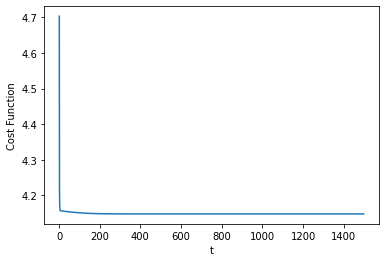

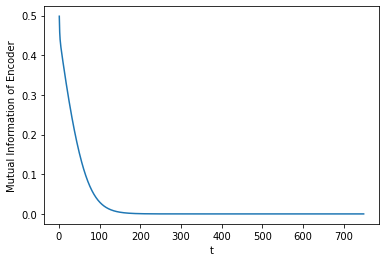

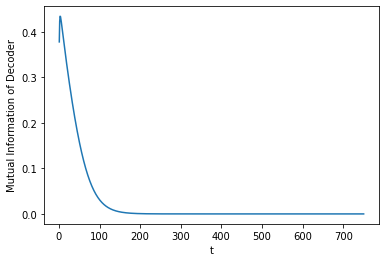

Given decoder Y_hat:
Initial matrix A:
[[0.6774 0.6646]
 [0.1673 0.451 ]
 [0.4128 0.2937]]

Initial covariance matrix of Z:
[[ 2.5322  0.7089 -1.3224]
 [ 0.7089  0.9246 -0.3362]
 [-1.3224 -0.3362  0.8986]]

The algorithm converges after 1455 iterations.

Optimal solution:
Matrix A:
[[0. 0.]
 [0. 0.]
 [0. 0.]]

Matrix B:
[[0. 0. 0.]
 [0. 0. 0.]]

Covariance matrix of Z:
[[1.   0.18 0.12]
 [0.18 1.   0.06]
 [0.12 0.06 1.  ]]

Covariance matrix of W:
[[ 1. -0.]
 [-0.  1.]]

Minimum value of the cost function:
4.1477

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[1.   0.18 0.12]
 [0.18 1.   0.06]
 [0.12 0.06 1.  ]]

Reconstruction error:
0.0


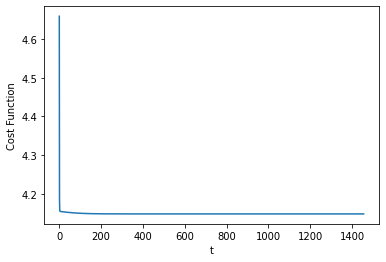

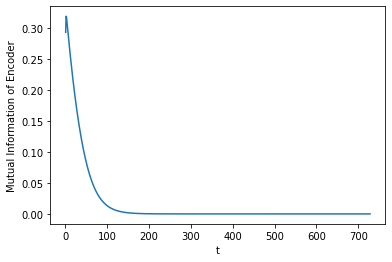

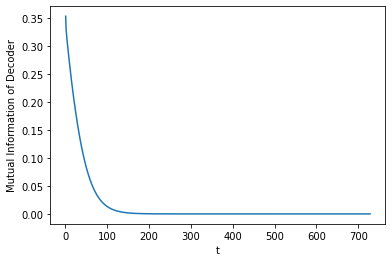

b. Diagonalized Sigma_Z

Given encoder X:
Initial matrix B:
[[0.4815 0.2557 0.16  ]
 [0.7554 0.0526 0.5054]]

Initial covariance matrix of W:
[[ 2.1963 -0.4423]
 [-0.4423  0.3971]]

The algorithm converges after 4105 iterations.

Optimal solution:
Matrix A:
[[0.0259 0.4801]
 [0.0183 0.3402]
 [0.0117 0.2167]]

Matrix B:
[[0.0224 0.0138 0.0082]
 [0.4158 0.2563 0.1514]]

Covariance matrix of Z:
[[0.7689 0.     0.    ]
 [0.     0.8839 0.    ]
 [0.     0.     0.9529]]

Covariance matrix of W:
[[ 0.9991 -0.0172]
 [-0.0172  0.6804]]

Minimum value of the cost function:
4.152

Mutual information of the encoder:
0.1932

Mutual information of the decoder:
0.1965

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[1.     0.1638 0.1043]
 [0.1638 1.     0.0739]
 [0.1043 0.0739 1.    ]]

Reconstruction error:
0.0245


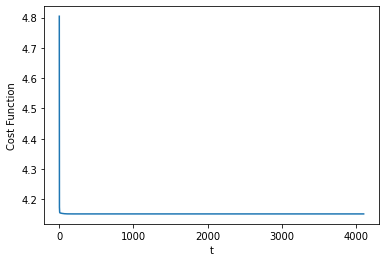

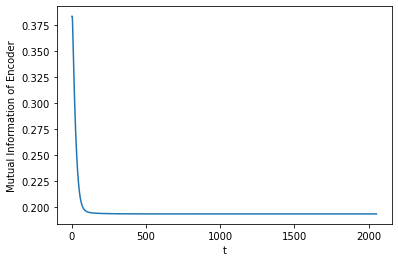

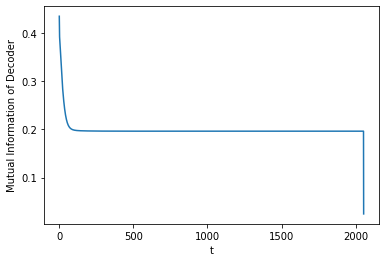

Given decoder Y_hat:
Initial matrix A:
[[0.094  0.1725]
 [0.9105 0.7884]
 [0.8471 0.8211]]

Initial covariance matrix of Z:
[[0.8371 0.     0.    ]
 [0.     0.0126 0.    ]
 [0.     0.     0.9841]]

The algorithm converges after 4426 iterations.

Optimal solution:
Matrix A:
[[0.4462 0.1789]
 [0.3162 0.1268]
 [0.2014 0.0807]]

Matrix B:
[[0.3865 0.2382 0.1407]
 [0.1549 0.0955 0.0564]]

Covariance matrix of Z:
[[0.7689 0.     0.    ]
 [0.     0.8839 0.    ]
 [0.     0.     0.9529]]

Covariance matrix of W:
[[ 0.7238 -0.1107]
 [-0.1107  0.9556]]

Minimum value of the cost function:
4.152

Mutual information of the encoder:
0.1932

Mutual information of the decoder:
0.1965

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[1.     0.1638 0.1043]
 [0.1638 1.     0.0739]
 [0.1043 0.0739 1.    ]]

Reconstruction error:
0.0245


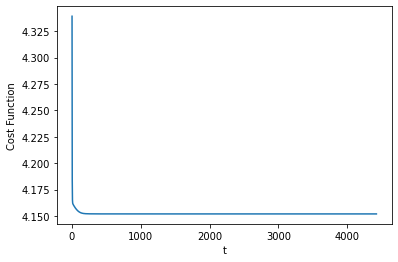

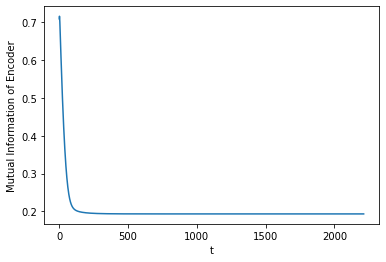

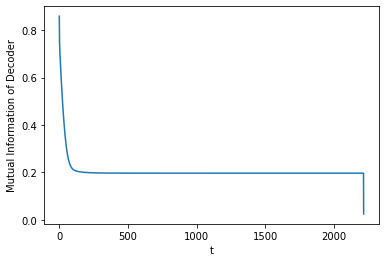

In [7]:
gamma = 0.98

for is_Sigma_Z_diagonal in (0, 1):
    if is_Sigma_Z_diagonal == 0:
        print(colored('a. Arbitrary Sigma_Z\n', 'red', attrs=['bold']))
    else: 
        print(colored('b. Diagonalized Sigma_Z\n', 'red', attrs=['bold']))  
    for flag in (0, 1):
        print_comprehensive_results(gamma, flag, m, n, is_Sigma_Z_diagonal)

#### Case 2: gamma = 1

a. Arbitrary Sigma_Z

Given encoder X:
Initial matrix B:
[[0.2003 0.5233 0.6432]
 [0.3387 0.3928 0.9353]]

Initial covariance matrix of W:
[[ 2.2064 -0.3799]
 [-0.3799  0.3501]]

The algorithm converges after 14 iterations.

Optimal solution:
Matrix A:
[[ 0.1137  0.1372]
 [ 0.3528  0.1174]
 [ 0.3178 -0.1509]]

Matrix B:
[[ 0.0185  0.3317  0.2957]
 [ 0.1396  0.1027 -0.1738]]

Covariance matrix of Z:
[[ 0.9682  0.1238  0.1046]
 [ 0.1238  0.8618 -0.0344]
 [ 0.1046 -0.0344  0.8762]]

Covariance matrix of W:
[[0.7869 0.0031]
 [0.0031 0.9426]]

Minimum value of the cost function:
4.2323

Mutual information of the encoder:
0.1494

Mutual information of the decoder:
0.1494

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[1.   0.18 0.12]
 [0.18 1.   0.06]
 [0.12 0.06 1.  ]]

Reconstruction error:
0.0


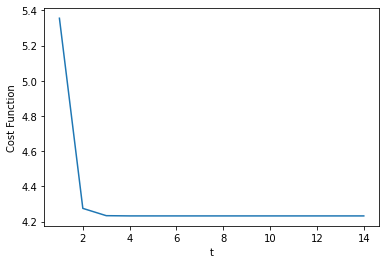

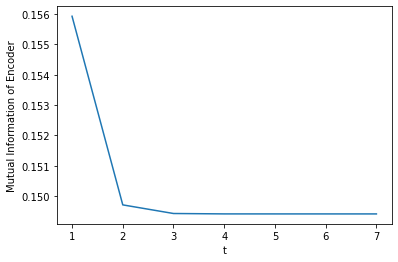

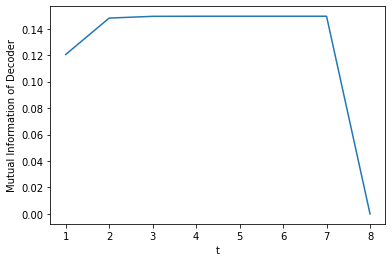

Given decoder Y_hat:
Initial matrix A:
[[0.1213 0.196 ]
 [0.7603 0.8096]
 [0.6128 0.6431]]

Initial covariance matrix of Z:
[[ 2.4202  1.387  -0.2773]
 [ 1.387   1.8642 -0.0577]
 [-0.2773 -0.0577  0.3332]]

The algorithm converges after 33 iterations.

Optimal solution:
Matrix A:
[[ 0.2753 -0.1125]
 [ 0.1798  0.619 ]
 [ 0.722  -0.0284]]

Matrix B:
[[ 0.1726  0.107   0.6948]
 [-0.2267  0.6623 -0.041 ]]

Covariance matrix of Z:
[[ 0.9116  0.2001 -0.0819]
 [ 0.2001  0.5845 -0.0522]
 [-0.0819 -0.0522  0.478 ]]

Covariance matrix of W:
[[ 0.4316 -0.027 ]
 [-0.027   0.5634]]

Minimum value of the cost function:
4.2323

Mutual information of the encoder:
0.7085

Mutual information of the decoder:
0.7085

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[1.   0.18 0.12]
 [0.18 1.   0.06]
 [0.12 0.06 1.  ]]

Reconstruction error:
0.0


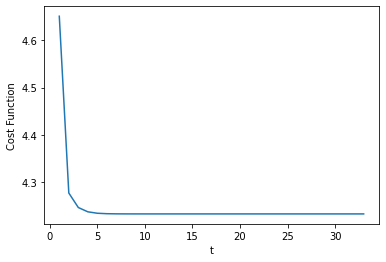

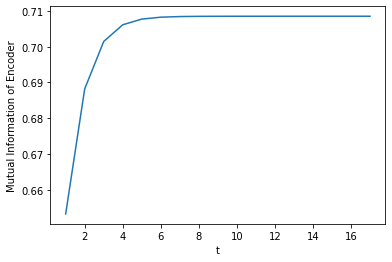

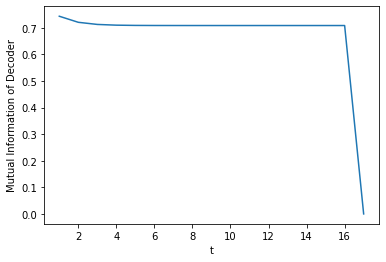

b. Diagonalized Sigma_Z

Given encoder X:
Initial matrix B:
[[0.897  0.6367 0.5311]
 [0.6525 0.6446 0.7896]]

Initial covariance matrix of W:
[[ 1.7149 -0.9195]
 [-0.9195  0.9267]]

The algorithm converges after 687 iterations.

Optimal solution:
Matrix A:
[[0.0012 0.6816]
 [0.0759 0.2639]
 [0.1795 0.1757]]

Matrix B:
[[-0.0331  0.0711  0.1792]
 [ 0.6452  0.1424  0.0898]]

Covariance matrix of Z:
[[0.5354 0.     0.    ]
 [0.     0.9246 0.    ]
 [0.     0.     0.9369]]

Covariance matrix of W:
[[ 0.9625 -0.0277]
 [-0.0277  0.5068]]

Minimum value of the cost function:
4.2323

Mutual information of the encoder:
0.3597

Mutual information of the decoder:
0.3597

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[1.   0.18 0.12]
 [0.18 1.   0.06]
 [0.12 0.06 1.  ]]

Reconstruction error:
0.0


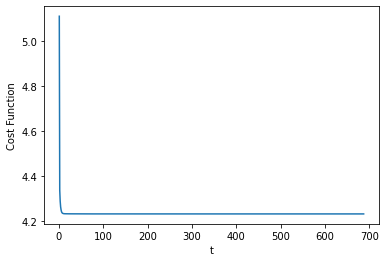

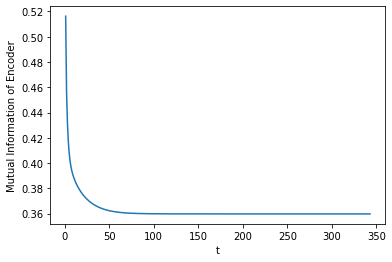

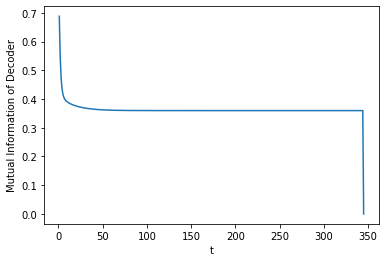

Given decoder Y_hat:
Initial matrix A:
[[0.973  0.5282]
 [0.4331 0.6074]
 [0.3019 0.6063]]

Initial covariance matrix of Z:
[[0.5253 0.     0.    ]
 [0.     0.5426 0.    ]
 [0.     0.     0.2908]]

The algorithm converges after 91 iterations.

Optimal solution:
Matrix A:
[[0.0894 0.6184]
 [0.0493 0.284 ]
 [0.5958 0.1079]]

Matrix B:
[[0.0163 0.0107 0.5932]
 [0.5832 0.1773 0.0273]]

Covariance matrix of Z:
[[0.6096 0.     0.    ]
 [0.     0.9169 0.    ]
 [0.     0.     0.6334]]

Covariance matrix of W:
[[ 0.6446 -0.0771]
 [-0.0771  0.5861]]

Minimum value of the cost function:
4.2323

Mutual information of the encoder:
0.4947

Mutual information of the decoder:
0.4947

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[1.   0.18 0.12]
 [0.18 1.   0.06]
 [0.12 0.06 1.  ]]

Reconstruction error:
0.0


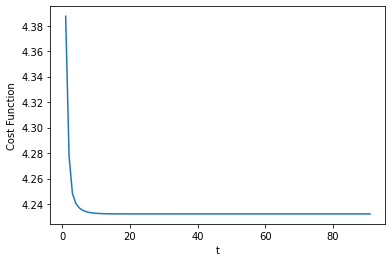

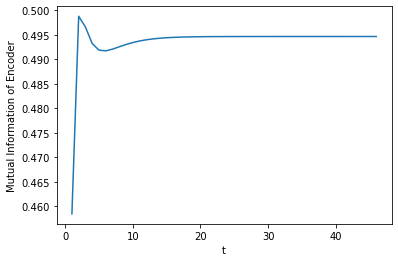

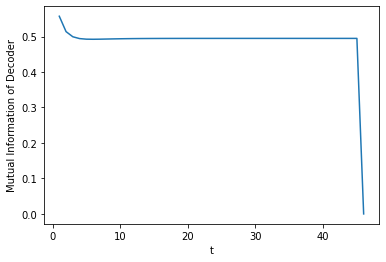

In [8]:
gamma = 1

for is_Sigma_Z_diagonal in (0, 1):
    if is_Sigma_Z_diagonal == 0:
        print(colored('a. Arbitrary Sigma_Z\n', 'red', attrs=['bold']))
    else: 
        print(colored('b. Diagonalized Sigma_Z\n', 'red', attrs=['bold']))  
    for flag in (0, 1):
        print_comprehensive_results(gamma, flag, m, n, is_Sigma_Z_diagonal)

#### Case 3: gamma > 1 -- choose gamma = 1.02

a. Arbitrary Sigma_Z

Given encoder X:
Initial matrix B:
[[0.6478 0.1299 0.0341]
 [0.752  0.9967 0.3028]]

Initial covariance matrix of W:
[[2.3624 0.8628]
 [0.8628 1.3503]]

The algorithm fails to converge after 3667 iterations due to NaN values.

Optimal solution:
Matrix A:
[[ 0.0134 -1.9537]
 [ 0.2718  2.3634]
 [ 0.2009  0.8163]]

Matrix B:
[[-0.5106 -1.3895  1.6202]
 [ 3.4959  3.8611 -0.3946]]

Covariance matrix of Z:
[[-1.0331  0.9888  0.5224]
 [ 0.9888 -0.9463 -0.5   ]
 [ 0.5224 -0.5    -0.2642]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
nan

Mutual information of the encoder:
36.2986

Mutual information of the decoder:
34.0688

Value of Sigma_X:
[[ 4.6032 -7.9063]
 [-7.9063 31.6311]]

Value of Sigma_Y_hat:
[[ 2.7842 -3.6251 -1.0698]
 [-3.6251  4.7132  1.4839]
 [-1.0698  1.4839  0.4426]]

Reconstruction error:
0.916


C:\Users\mhvu1\AppData\Local\Temp\ipykernel_22488\938477731.py:63: RuntimeWarning: invalid value encountered in log
  n * np.log(2 * pi) - np.log(det(Sigma_Z)))


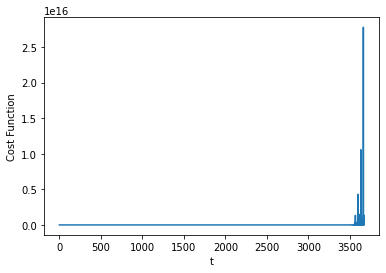

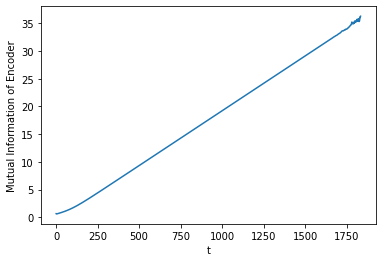

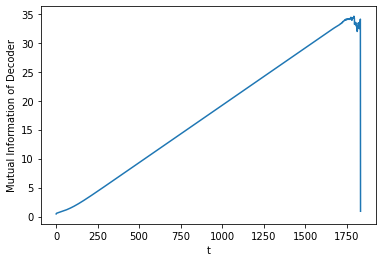

Given decoder Y_hat:
Initial matrix A:
[[0.8626 0.6093]
 [0.1742 0.9393]
 [0.0536 0.8031]]

Initial covariance matrix of Z:
[[ 2.7288  1.2388 -0.6072]
 [ 1.2388  1.3633 -0.6092]
 [-0.6072 -0.6092  0.973 ]]

The algorithm fails to converge after 3862 iterations due to NaN values.

Optimal solution:
Matrix A:
[[ -17.6809   26.4601]
 [-141.5379 -107.5214]
 [ -16.8229   11.3015]]

Matrix B:
[[-14.8989  -0.0476   9.702 ]
 [ -5.569   -0.0305   3.8112]]

Covariance matrix of Z:
[[-0.0032 -0.0756 -0.0052]
 [-0.0756 -1.8127 -0.125 ]
 [-0.0052 -0.125  -0.0086]]

Covariance matrix of W:
[[0. 0.]
 [0. 0.]]

Minimum value of the cost function:
nan

Mutual information of the encoder:
39.4027

Mutual information of the decoder:
38.3848

Value of Sigma_X:
[[281.6172 106.7541]
 [106.7541  40.4939]]

Value of Sigma_Y_hat:
[[ 1012.7491  -342.5759   596.4788]
 [ -342.5759 31592.0117  1165.8005]
 [  596.4788  1165.8005   410.7258]]

Reconstruction error:
1553.1746


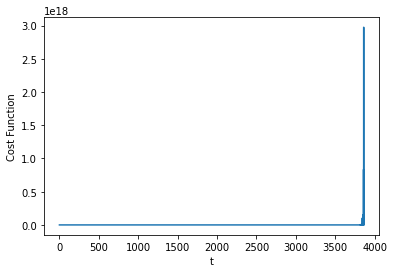

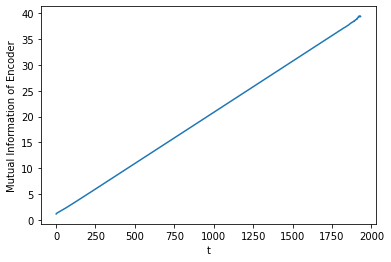

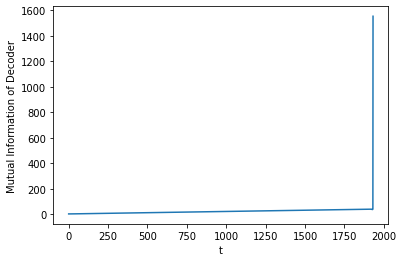

b. Diagonalized Sigma_Z

Given encoder X:
Initial matrix B:
[[0.6542 0.4738 0.118 ]
 [0.3758 0.818  0.2222]]

Initial covariance matrix of W:
[[ 2.4147 -0.5789]
 [-0.5789  0.7837]]

The algorithm converges after 6953 iterations.

Optimal solution:
Matrix A:
[[ 0.207   0.0327]
 [ 0.9205 -0.378 ]
 [ 0.4326  0.8961]]

Matrix B:
[[ 0.      0.9067  0.3825]
 [-0.     -0.4377  0.9313]]

Covariance matrix of Z:
[[0.9556 0.     0.    ]
 [0.     0.     0.    ]
 [0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
-143552238122433.16

Mutual information of the encoder:
67.7313

Mutual information of the decoder:
67.7214

Value of Sigma_X:
[[1.0099 0.    ]
 [0.     1.0099]]

Value of Sigma_Y_hat:
[[0.9996 0.1782 0.1188]
 [0.1782 0.9902 0.0594]
 [0.1188 0.0594 0.9902]]

Reconstruction error:
0.0087


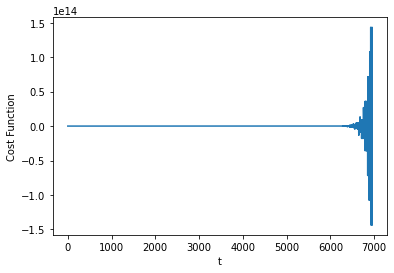

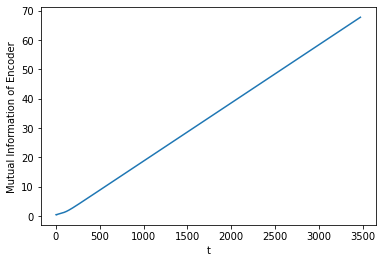

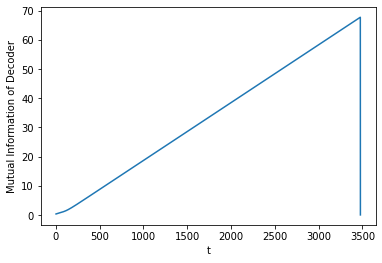

Given decoder Y_hat:
Initial matrix A:
[[0.2906 0.3332]
 [0.1601 0.5118]
 [0.4428 0.4074]]

Initial covariance matrix of Z:
[[0.3437 0.     0.    ]
 [0.     0.4115 0.    ]
 [0.     0.     0.909 ]]

The algorithm converges after 6824 iterations.

Optimal solution:
Matrix A:
[[ 0.5192  0.8489]
 [ 0.1263  0.1327]
 [ 0.9051 -0.4136]]

Matrix B:
[[ 0.4207  0.      0.8636]
 [ 0.9207  0.     -0.5282]]

Covariance matrix of Z:
[[0.     0.     0.    ]
 [0.     0.9661 0.    ]
 [0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
-143552238122433.12

Mutual information of the encoder:
68.52

Mutual information of the decoder:
68.5101

Value of Sigma_X:
[[ 1.0099 -0.    ]
 [-0.      1.01  ]]

Value of Sigma_Y_hat:
[[0.9902 0.1782 0.1188]
 [0.1782 0.9997 0.0594]
 [0.1188 0.0594 0.9901]]

Reconstruction error:
0.009


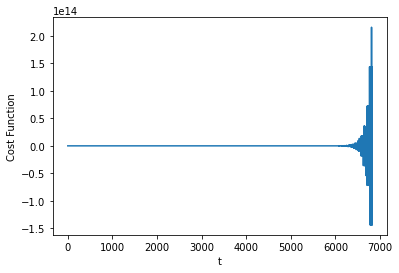

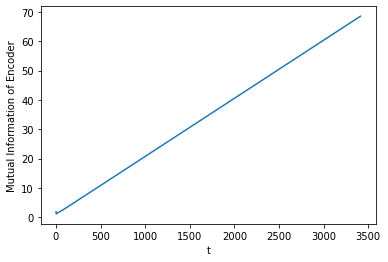

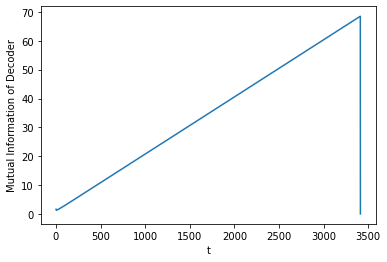

In [9]:
gamma = 1.02

for is_Sigma_Z_diagonal in (0, 1):
    if is_Sigma_Z_diagonal == 0:
        print(colored('a. Arbitrary Sigma_Z\n', 'red', attrs=['bold']))
    else: 
        print(colored('b. Diagonalized Sigma_Z\n', 'red', attrs=['bold']))
    for flag in (0, 1):
        print_comprehensive_results(gamma, flag, m, n, is_Sigma_Z_diagonal)

## II. Mutual information and reconstruction error across gammas

In [10]:
def get_mutual_info_recon_err(sol, is_varied):
    en_mi, de_mi = sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+3]
    recon_err = round(sol[-1], 4)
    mi_arr = np.round(np.array([en_mi, de_mi]), 4)
    
    if is_varied == 1:
        print('Mutual information of encoder and decoder = {}'.format(mi_arr))
        print('Reconstruction error = {}'.format(recon_err))
    else:
        print('Mutual information of encoder and decoder = {}'.format(mi_arr))

    return np.concatenate((mi_arr,  [recon_err]))
    
def print_mutual_info_recon_err(flag, is_diagonal, is_varied):
    if flag == 0:
        # Generate random initial encoder inputs (B, Sigma_W)
        B, Sigma_W = initial_inputs(flag, is_diagonal)[1:1+m*n].reshape((m, n)), initial_inputs(flag, is_diagonal)[1+m*n:1+m*n+m*m].reshape((m, m))
    else:
        # Generate random initial decoder inputs (A, Sigma_Z)
        A, Sigma_Z = initial_inputs(flag, is_diagonal)[1:1+n*m].reshape((n, m)), initial_inputs(flag, is_diagonal)[1+n*m:1+n*m+n*n].reshape((n, n))
    
    # Print results
    opt_sol = rate_distortion(initial_inputs(flag, is_diagonal), is_diagonal)
    mi_recon_err_arr = get_mutual_info_recon_err(opt_sol, is_varied)
    
    return mi_recon_err_arr

def plot_mutual_info_gamma(x, y1, z1, y2, z2):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Left subplot: mutual information given arbitrary Sigma_Z
    ax1.scatter(x, y1, color='black', marker='^', s=20, label='Encoder')
    ax1.scatter(x, z1, color='red', marker='o', s=10, label='Decoder')
    ax1.set_xlabel('gamma', fontsize=10)
    ax1.set_ylabel('Mutual Information', fontsize=10)
    ax1.legend()

    # Right subplot: mutual information given diagonalized Sigma_Z
    ax2.scatter(x, y2, color='black', marker='^', s=20, label='Encoder')
    ax2.scatter(x, z2, color='red', marker='o', s=10, label='Decoder')
    ax2.set_xlabel('gamma', fontsize=10)
    ax2.set_ylabel('Mutual Information', fontsize=10)
    ax2.legend()

    # Adjust layout and display plot
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.subplots_adjust(wspace=0.3)
    plt.show()
    
def plot_recon_error_gamma(x, y1, y2):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Left subplot: reconstruction error given arbitrary Sigma_Z
    ax1.scatter(x, y1, color='red', marker='o', s=10)
    ax1.set_xlabel('gamma', fontsize=10)
    ax1.set_ylabel('Reconstruction Error', fontsize=10)

    # Right subplot: reconstruction error given diagonalized Sigma_Z
    ax2.scatter(x, y2, color='red', marker='o', s=10)
    ax2.set_xlabel('gamma', fontsize=10)
    ax2.set_ylabel('Reconstruction Error', fontsize=10)

    # Adjust layout and display plot
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.subplots_adjust(wspace=0.4)
    plt.show()

### 1. Input

In [11]:
# Create an array of gamma = [0.9, 1.1] with step size 0.01
gamma_arr = np.arange(0.9, 1.1, 0.01).round(2)

print(colored('An array of gamma:', 'blue', attrs=['bold']))
print(gamma_arr)

An array of gamma:
[0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.   1.01 1.02 1.03
 1.04 1.05 1.06 1.07 1.08 1.09 1.1 ]


### 2. Numerical results

In [12]:
# Compute mutual information and reconstruction error given X and Y_hat across gammas   
# Initiate arrays given arbitrary Sigma_Z
en_mi_arr_X_1, de_mi_arr_X_1 = [], []
en_mi_arr_Y_1, de_mi_arr_Y_1 = [], []
recon_err_X_1, recon_err_Y_1 = [], []

# Initiate arrays given diagonalized Sigma_Z
en_mi_arr_X_2, de_mi_arr_X_2 = [], []
en_mi_arr_Y_2, de_mi_arr_Y_2 = [], []
recon_err_X_2, recon_err_Y_2 = [], []

is_gamma_varied = 1

for is_Sigma_Z_diagonal in (0, 1):
    if is_Sigma_Z_diagonal == 0:
        print(colored('a. Arbitrary Sigma_Z', 'red', attrs=['bold']))
    else: 
        print(colored('\nb. Diagonalized Sigma_Z', 'red', attrs=['bold']))
        
    for i, gamma in enumerate(gamma_arr):
        print(f"\ngamma = {gamma}:")
        for flag, mi_recon_arr in enumerate([print_mutual_info_recon_err(0, is_Sigma_Z_diagonal, is_gamma_varied),
                                             print_mutual_info_recon_err(1, is_Sigma_Z_diagonal, is_gamma_varied)]):
            en_mi, de_mi, recon_err = mi_recon_arr

            if is_Sigma_Z_diagonal == 0:
                # Arbitrary Sigma_Z
                if flag == 0:
                    en_mi_arr_X_1 = np.concatenate((en_mi_arr_X_1, [en_mi]))
                    de_mi_arr_X_1 = np.concatenate((de_mi_arr_X_1, [de_mi]))
                    recon_err_X_1 = np.concatenate((recon_err_X_1, [recon_err]))
                else:
                    en_mi_arr_Y_1 = np.concatenate((en_mi_arr_Y_1, [en_mi]))
                    de_mi_arr_Y_1 = np.concatenate((de_mi_arr_Y_1, [de_mi]))
                    recon_err_Y_1 = np.concatenate((recon_err_Y_1, [recon_err]))
            else:
                # Diagonalized Sigma_Z
                if flag == 0:
                    en_mi_arr_X_2 = np.concatenate((en_mi_arr_X_2, [en_mi]))
                    de_mi_arr_X_2 = np.concatenate((de_mi_arr_X_2, [de_mi]))
                    recon_err_X_2 = np.concatenate((recon_err_X_2, [recon_err]))
                else:
                    en_mi_arr_Y_2 = np.concatenate((en_mi_arr_Y_2, [en_mi]))
                    de_mi_arr_Y_2 = np.concatenate((de_mi_arr_Y_2, [de_mi]))  
                    recon_err_Y_2 = np.concatenate((recon_err_Y_2, [recon_err]))

a. Arbitrary Sigma_Z

gamma = 0.9:

The algorithm converges after 302 iterations.

Mutual information of encoder and decoder = [0. 0.]
Reconstruction error = 0.0

The algorithm converges after 309 iterations.

Mutual information of encoder and decoder = [0. 0.]
Reconstruction error = 0.0

gamma = 0.91:

The algorithm converges after 360 iterations.

Mutual information of encoder and decoder = [0. 0.]
Reconstruction error = 0.0

The algorithm converges after 389 iterations.

Mutual information of encoder and decoder = [0. 0.]
Reconstruction error = 0.0

gamma = 0.92:

The algorithm converges after 398 iterations.

Mutual information of encoder and decoder = [0. 0.]
Reconstruction error = 0.0

The algorithm converges after 409 iterations.

Mutual information of encoder and decoder = [0. 0.]
Reconstruction error = 0.0

gamma = 0.93:

The algorithm converges after 440 iterations.

Mutual information of encoder and decoder = [0. 0.]
Reconstruction error = 0.0

The algorithm converges after 

C:\Users\mhvu1\AppData\Local\Temp\ipykernel_22488\938477731.py:63: RuntimeWarning: invalid value encountered in log
  n * np.log(2 * pi) - np.log(det(Sigma_Z)))



The algorithm fails to converge after 6546 iterations due to NaN values.

Mutual information of encoder and decoder = [35.0656 31.6254]
Reconstruction error = 0.8597

gamma = 1.02:

The algorithm fails to converge after 3585 iterations due to Singular matrix.

Mutual information of encoder and decoder = [36.1711 34.8649]
Reconstruction error = 4.1142

The algorithm fails to converge after 3720 iterations due to Singular matrix.

Mutual information of encoder and decoder = [36.1303 38.2598]
Reconstruction error = 960.8082

gamma = 1.03:

The algorithm fails to converge after 2335 iterations due to NaN values.

Mutual information of encoder and decoder = [35.5435 34.6263]
Reconstruction error = 0.9104

The algorithm fails to converge after 2654 iterations due to Singular matrix.

Mutual information of encoder and decoder = [38.966  37.9699]
Reconstruction error = 4.55

gamma = 1.04:

The algorithm fails to converge after 1891 iterations due to NaN values.

Mutual information of encoder 

### 3. Plots

Given encoder X:


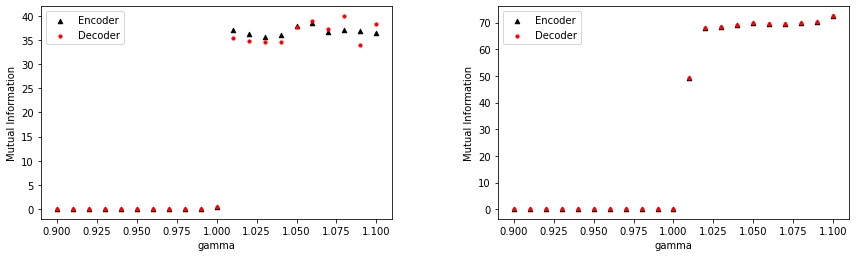

Given decoder Y_hat:


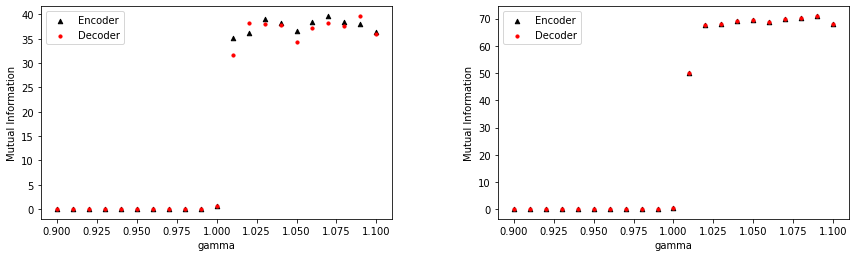

In [13]:
print(colored('Given encoder X:', attrs=['bold']))
plot_mutual_info_gamma(gamma_arr, en_mi_arr_X_1, de_mi_arr_X_1, en_mi_arr_X_2, de_mi_arr_X_2)    

print(colored('Given decoder Y_hat:', attrs=['bold']))
plot_mutual_info_gamma(gamma_arr, en_mi_arr_Y_1, de_mi_arr_Y_1, en_mi_arr_Y_2, de_mi_arr_Y_2) 

Given encoder X:


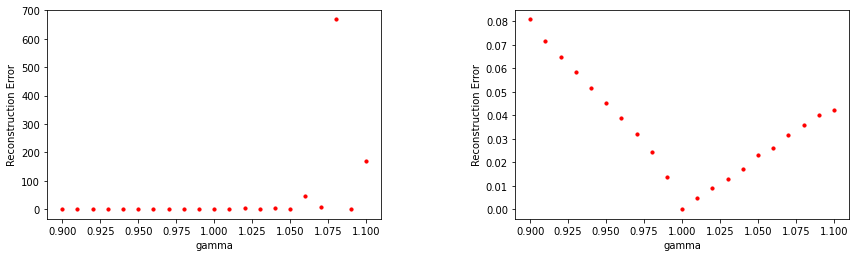

Given decoder Y_hat:


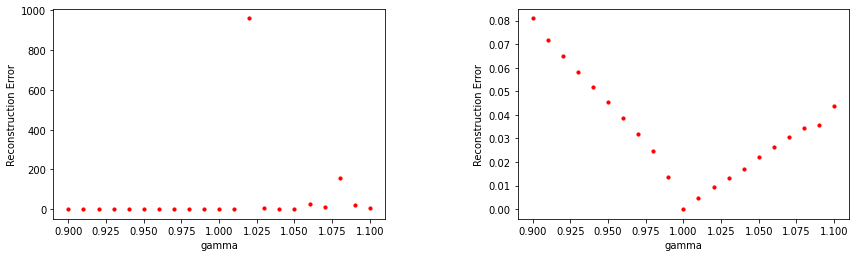

In [14]:
print(colored('Given encoder X:', attrs=['bold']))
plot_recon_error_gamma(gamma_arr, recon_err_X_1, recon_err_X_2)    

print(colored('Given decoder Y_hat:', attrs=['bold']))
plot_recon_error_gamma(gamma_arr, recon_err_Y_1, recon_err_Y_2) 

## III. Mutual information given gamma = 1

In [15]:
def mutual_info_boxplot(x, y1, y2, ax):
    # Compute mean, median, and std of data
    mean_y1, median_y1, std_y1 = np.mean(y1), np.median(y1), np.std(y1)
    mean_y2, median_y2, std_y2 = np.mean(y2), np.median(y2), np.std(y2)

    # Create the boxplot
    bp1 = ax.boxplot(y1, positions=[1], widths=0.6, showfliers=True, patch_artist=True,
                     boxprops=dict(facecolor='C0', color='C0'), medianprops=dict(color='red'))
    bp2 = ax.boxplot(y2, positions=[2], widths=0.6, showfliers=True, patch_artist=True,
                     boxprops=dict(facecolor='C1', color='C1'), medianprops=dict(color='red'))
    ax.set_xticklabels(x, fontsize=10)
    ax.set_ylabel('Mutual Information', fontsize=10)

    # Add outlier points
    for element in ['fliers']:
        plt.setp(bp1[element], marker='o', markersize=5, markeredgecolor='C0', alpha=0.5)
        plt.setp(bp2[element], marker='o', markersize=5, markeredgecolor='C1', alpha=0.5)

    # Add legend
    bp1_mean_median_std = f"Mean: {mean_y1:.2f}\nMedian: {median_y1:.2f}\nStd: {std_y1:.2f}"
    bp2_mean_median_std = f"Mean: {mean_y2:.2f}\nMedian: {median_y2:.2f}\nStd: {std_y2:.2f}"
    legend_elements = [Patch(facecolor='C0', edgecolor='C0', label=bp1_mean_median_std),
                       Patch(facecolor='C1', edgecolor='C1', label=bp2_mean_median_std)]
    ax.legend(handles=legend_elements)
    
def plot_mutual_info(y1, z1, y2, z2):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Plot boxplots side by side
    mutual_info_boxplot(['Encoder', 'Decoder'], y1, z1, ax1)
    mutual_info_boxplot(['Encoder', 'Decoder'], y2, z2, ax2)

    # Adjust layout and display plot
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.subplots_adjust(wspace=0.4)
    plt.show()

### 1. Input

In [16]:
# Create an array of gamma of 100 values of 1
gamma_arr = [1] * 100

print(colored('An array of gamma:', 'blue', attrs=['bold']))
print(gamma_arr)

An array of gamma:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### 2. Numerical results

In [17]:
# Compute mutual information for encoder and decoder given X and Y_hat for 100 iterations with gamma set to 1
en_mi_arr_X_1, de_mi_arr_X_1 = [], []
en_mi_arr_Y_1, de_mi_arr_Y_1 = [], []

en_mi_arr_X_2, de_mi_arr_X_2 = [], []
en_mi_arr_Y_2, de_mi_arr_Y_2 = [], []

is_gamma_varied = 0

for is_Sigma_Z_diagonal in (0, 1):
    if is_Sigma_Z_diagonal == 0:
        print(colored('a. Arbitrary Sigma_Z', 'red', attrs=['bold']))
    else: 
        print(colored('\nb. Diagonalized Sigma_Z', 'red', attrs=['bold']))
        
    for i, gamma in enumerate(gamma_arr):
        print(colored('\nIteration = {}:'.format(i+1), attrs = ['bold']))
        for flag, mi_arr in enumerate([print_mutual_info_recon_err(0, is_Sigma_Z_diagonal, is_gamma_varied),
                                       print_mutual_info_recon_err(1, is_Sigma_Z_diagonal, is_gamma_varied)]):
            en_mi, de_mi = mi_arr[:2]

            if is_Sigma_Z_diagonal == 0:
                # Arbitrary Sigma_Z
                if flag == 0:
                    en_mi_arr_X_1 = np.concatenate((en_mi_arr_X_1, [en_mi]))
                    de_mi_arr_X_1 = np.concatenate((de_mi_arr_X_1, [de_mi]))
                else:
                    en_mi_arr_Y_1 = np.concatenate((en_mi_arr_Y_1, [en_mi]))
                    de_mi_arr_Y_1 = np.concatenate((de_mi_arr_Y_1, [de_mi]))
            else:
                # Diagonalized Sigma_Z
                if flag == 0:
                    en_mi_arr_X_2 = np.concatenate((en_mi_arr_X_2, [en_mi]))
                    de_mi_arr_X_2 = np.concatenate((de_mi_arr_X_2, [de_mi]))
                else:
                    en_mi_arr_Y_2 = np.concatenate((en_mi_arr_Y_2, [en_mi]))
                    de_mi_arr_Y_2 = np.concatenate((de_mi_arr_Y_2, [de_mi]))

a. Arbitrary Sigma_Z

Iteration = 1:

The algorithm converges after 48 iterations.

Mutual information of encoder and decoder = [0.6066 0.6066]

The algorithm converges after 47 iterations.

Mutual information of encoder and decoder = [0.6184 0.6184]

Iteration = 2:

The algorithm converges after 64 iterations.

Mutual information of encoder and decoder = [0.755 0.755]

The algorithm converges after 22 iterations.

Mutual information of encoder and decoder = [0.3188 0.3188]

Iteration = 3:

The algorithm converges after 26 iterations.

Mutual information of encoder and decoder = [0.3318 0.3318]

The algorithm converges after 33 iterations.

Mutual information of encoder and decoder = [0.4675 0.4675]

Iteration = 4:

The algorithm converges after 24 iterations.

Mutual information of encoder and decoder = [0.3613 0.3613]

The algorithm converges after 39 iterations.

Mutual information of encoder and decoder = [0.5403 0.5403]

Iteration = 5:

The algorithm converges after 12 iterations.

### 3. Plots

Given encoder X:


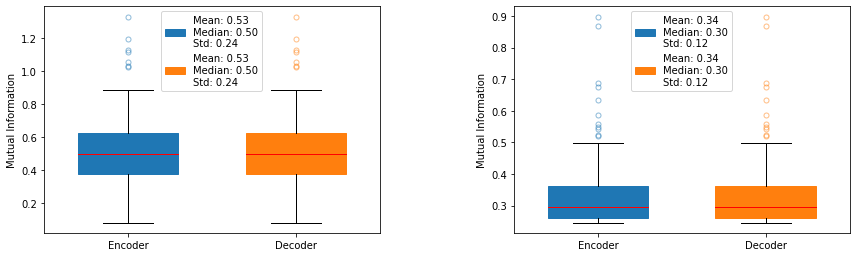

Given decoder Y_hat:


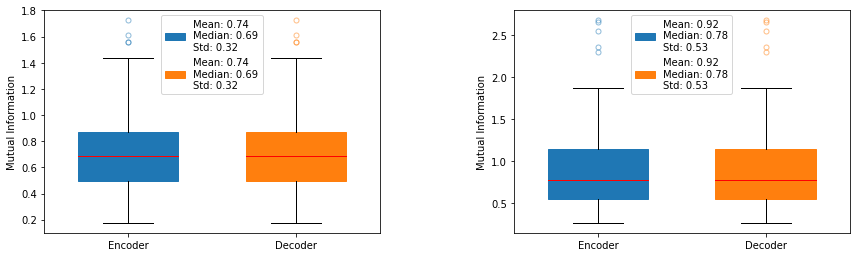

In [18]:
print(colored('Given encoder X:', attrs=['bold']))
plot_mutual_info(en_mi_arr_X_1, de_mi_arr_X_1, en_mi_arr_X_2, de_mi_arr_X_2)

print(colored('Given decoder Y_hat:', attrs=['bold']))
plot_mutual_info(en_mi_arr_Y_1, de_mi_arr_Y_1, en_mi_arr_Y_2, de_mi_arr_Y_2)